In [1]:
    """poser uses dask to parallelize compositions
    """
    import functools
    import inspect

    import toolz

    DASK = False


    def split_every(object, split_every=None, *, function=None):
        global DASK
        if dask:
            import dask.bag
            return getattr(dask.bag, getattr(function, "__name__"))(object, split_every)
        return function(object)


    all = functools.partial(split_every, function=all)
    any = functools.partial(split_every, function=any)

In [2]:
    from poser import *

    
    import toolz

    
    def to_delayed(f, *args, delayed=None, **kwargs):
        import functools, typing
        import poser, importlib
        import dask.bag.random, toolz
        Delayed =__import__("importlib").import_module('dask.delayed').Delayed

        function_mapping = {
            all: dask.bag.Bag.all,
            any: dask.bag.Bag.any,
            map: dask.bag.Bag.map,
            sum: dask.bag.Bag.sum,
            toolz.itertoolz.take: dask.bag.Bag.take,
            toolz.itertoolz.count: dask.bag.Bag.count,
            toolz.itertoolz.unique: dask.bag.Bag.distinct,
            poser.util.filter: dask.bag.Bag.filter,
            __import__("_operator").concat: dask.bag.Bag.flatten,
            toolz.sandbox.fold: dask.bag.Bag.fold,
            "frequencies": dask.bag.Bag.frequencies,
            toolz.itertoolz.groupby: dask.bag.Bag.groupby,
            toolz.itertoolz.join: dask.bag.Bag.join,
            poser.util.map: dask.bag.Bag.map,
            "map_partitions": dask.bag.Bag.map_partitions,
            max: dask.bag.Bag.max,
            __import__("statistics").mean: dask.bag.Bag.mean,
            min: dask.bag.Bag.min,
            toolz.itertoolz.pluck: dask.bag.Bag.pluck,
            __import__("itertools").product: dask.bag.Bag.product,
            __import__("_functools").reduce: dask.bag.Bag.reduction,
            toolz.itertoolz.random_sample: dask.bag.Bag.random_sample,
            toolz.itertoolz.remove: dask.bag.Bag.remove,
            "repartition": "",
            __import__("itertools").starmap: dask.bag.Bag.starmap,
            __import__("statistics").stdev: dask.bag.Bag.std,
            sum: dask.bag.Bag.sum,
            toolz.itertoolz.take: dask.bag.Bag.take,
            "to_*": ...,
            toolz.itertoolz.topk: dask.bag.Bag.topk,
            __import__("statistics").variance: dask.bag.Bag.var,
            "read_*": ...,
            "from_": ...,
            "concat": dask.bag.concat,
            zip: dask.bag.zip,
            __import__("random").choices: dask.bag.random.choices,
            __import__("random").sample: dask.bag.random.sample,
            "to_*": ...,
        }
            
        if isinstance(f, λ):
            if f.args:
                delayed = to_delayed(f.args[0], **f.kwargs)
                
            for g in list(f):
                delayed = to_delayed(g, delayed=delayed)
            return delayed
        
        if isinstance(f, typing.Sequence):
            return dask.bag.from_sequence(f, **kwargs)
        
        if isinstance(f, functools.partial):
            f, args, kwargs = f.func, f.args, f.keywords
            
            
        if f in {poser.util.map, poser.util.filter}:
            [kwargs.pop(x, None) for x in "key property".split()]
            
            
        if f in function_mapping:
            if delayed is None:
                return function_mapping[f](*args, **kwargs)
            
            if isinstance(delayed, Delayed):
                delayed = dask.bag.from_delayed(delayed)

            return function_mapping[f](delayed, *args, **kwargs)
        
        if delayed is None:
            return dask.delayed(f)
        
        
        return dask.delayed(f)(delayed)
        
            

    import poser

    λ.delayed = to_delayed
    λ.visualize = λ[to_delayed].methodcaller('visualize')
    λ.compute = λ[to_delayed].methodcaller('compute')
    λ.to_dataframe = λ[to_delayed].methodcaller('to_dataframe')

In [3]:
    f = λ(range(10))[
        -λ.mod(2) # filter
        :λ.mul(10)
        :sum
    ]

In [4]:
    fd = (
        λ(range(100), npartitions=6)
        .filter(-λ.mod(2))
        .map(λ.mul(10)) # map
        [sum] # reduce
    )

In [5]:
    fds = λ(range(100), npartitions=6)[
        
        -λ.mod(2) # filter
        
        :λ.mul(10) # map
        
        :sum # reduce
    
    ]

In [6]:
     fd.visualize(), fd.delayed()

(<IPython.core.display.Image object>, <dask.bag.core.Item at 0x7f8cb6f805d0>)

In [7]:
    fd.compute()

24500

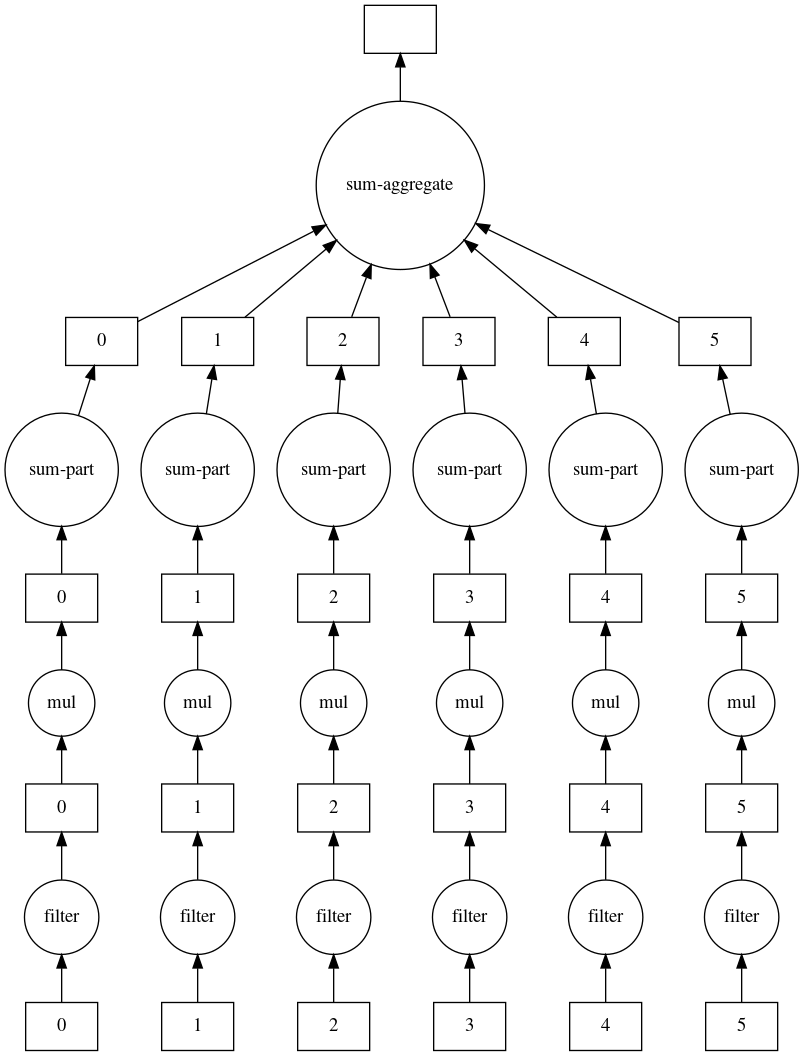

In [8]:
    fd.visualize()

In [9]:
    fd = λ(range(100))[
        -λ[Λ%2] # filter
        :λ[Λ*10]
        :sum
    ]
    fd.compute()

24500

In [10]:
    λ(10)[{'ani': range, 'foo': type}]+...

{'ani': range(0, 10), 'foo': int}

In [11]:
    f = λ(λ.range(20)(), npartitions=10)[
        -λ.mod(2) # filter divisible by two.
        :λ[{"type": type, "str": str, "range": range}] # map a dictionary
    ].to_dataframe(); f

,type,str,range
npartitions=10,,,
,object,object,object
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [12]:
    f, f.compute().T

(Dask DataFrame Structure:
                   type     str   range
 npartitions=10                        
                 object  object  object
                    ...     ...     ...
 ...                ...     ...     ...
                    ...     ...     ...
                    ...     ...     ...
 Dask Name: to_dataframe, 40 tasks,
                    0              0              0                   0  \
 type   <class 'int'>  <class 'int'>  <class 'int'>       <class 'int'>   
 str                0              2              4                   6   
 range             ()         (0, 1)   (0, 1, 2, 3)  (0, 1, 2, 3, 4, 5)   
 
                               0                               0  \
 type              <class 'int'>                   <class 'int'>   
 str                           8                              10   
 range  (0, 1, 2, 3, 4, 5, 6, 7)  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)   
 
                                             0  \
 type                          

    !gist poser-dask.ipynb -u6bfa54a91a7fd2e9b6f22109119b254a

In [13]:
    from sympy.abc import *

use dask and sympy together.

In [15]:
    assert λ(λ.range(20)(), npartitions=10).map(
        x+10
    ).sum().compute() == λ(λ.range(20)()).map(x+10).sum()()